# Project 5: Moon Phase Calendar with Events
**Authors:** Eling Cheng and Allison Trusko  
**Course:** Astron 1221  
**Semester:** Fall 2025

## Goal:
- Build a lunar calendar for 12 months that computes moon phase, illuminated fraction, moon rise/set times, and correlates this with user events loaded from `events.csv`.
- Identify dark-sky observing windows (illumination < 20%), supermoons, and lunar eclipses.

## Data & Tools:
- **Skyfield**: ephemeris & almanac calculations
- **Pandas / NumPy**: data wrangling
- **Matplotlib**: visualization
- **events.csv**: user events (see schema below)



## First Step:

 First, we will start by installing the necessary libraries to run this code, as shown below:

In [42]:
# Requirements cell (include in the notebook so graders can re-run)
%pip install --upgrade pip
%pip install skyfield pandas numpy matplotlib astropy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 🌙 Project Setup: Loading Astronomical Data with Skyfield

In this section, we initialize all the necessary tools and datasets for our Moon Phase Calendar project.
The goal is to use the Skyfield
 library to compute accurate lunar positions, illumination, and phase information throughout the year.

### What this code does:

1. Imports required libraries
   
   Includes Python’s built-in modules (os, datetime, math), data handling libraries (pandas, numpy), and plotting tools (matplotlib).

2. Loads astronomical data (ephemerides)
  
   Uses Skyfield’s load() function to access the DE421 planetary ephemeris, which provides precise orbital data for the Earth, Moon, and Sun.
     - If the file doesn’t exist locally, it’s downloaded automatically and saved to a local data/ directory.
    - This ensures offline repeatability and reproducibility for future runs.

3. Defines constants and configuration
  
   Sets a 20% illumination threshold (ILLUM_THRESHOLD = 0.20) that will later be used to identify dark-sky windows which identifies optimal nights for astronomical observing.

After running this setup cell, we’ll have the fundamental objects (earth, moon, sun, and ts) ready to calculate lunar phases, illumination percentages, and observing conditions.

In [43]:
# Imports
import os
from datetime import datetime, timedelta
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Skyfield imports
from skyfield.api import load, Topos
from skyfield import almanac

# Notebook display convenience
%matplotlib inline

# Create a data dir for ephemeris if not present
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)

# Load timescale and ephemeris (this may download data to data/)
# If you want to avoid downloading each run, run once and commit the data/ files.
ts = load.timescale()
eph = load('de421.bsp')  # will download if not present
earth = eph['earth']
moon = eph['moon']
sun = eph['sun']

# Constants
ILLUM_THRESHOLD = 0.20   # 20% illuminated -> dark-sky window threshold


In [44]:
def generate_lunar_dataframe(start_date, end_date, observer_lat=None, observer_lon=None):
    """
    Generate a pandas DataFrame with lunar information for each day from start_date to end_date inclusive.
    - Dates are at midnight UTC (00:00 UTC); you can change sampling to local midnight if desired.
    - observer_lat/lon: floats for Topos to compute rise/set times. If None, rise/set columns will be NaN.
    Returns DataFrame indexed by date (datetime.date).
    """
    # build times list at 00:00 UTC for each day
    start = pd.to_datetime(start_date).normalize()
    end = pd.to_datetime(end_date).normalize()
    days = pd.date_range(start, end, freq='D')
    # create Skyfield Time object for the days at UT 00:00
    t = ts.utc(days.year.values, days.month.values, days.day.values, 0, 0, 0)

    # compute phase angle using almanac.moon_phase
    phase_angles = almanac.moon_phase(eph, t)  # returns Angle object
    # illuminated fraction formula
    illum_frac = (1 + np.cos(phase_angles.radians)) / 2.0

    # distances: compute geocentric vector from earth to moon
    # We'll observe moon from Earth's center for geocentric distance
    moon_pos = earth.at(t).observe(moon)
    distances_au = moon_pos.distance().au  # in AU
    # convert AU to km (1 AU ≈ 149597870.7 km)
    AU_TO_KM = 149597870.7
    distances_km = distances_au * AU_TO_KM

    # compute "phase name" (approx) using phase angle degrees
    phase_deg = phase_angles.degrees
    def phase_label(deg):
        deg = deg % 360
        if deg < 45 or deg >= 315:
            return 'New'
        elif 45 <= deg < 135:
            return 'First Quarter'
        elif 135 <= deg < 225:
            return 'Full'
        elif 225 <= deg < 315:
            return 'Last Quarter'
        else:
            return 'Unknown'
    phase_names = [phase_label(d) for d in phase_deg]

    # prepare DataFrame
    df = pd.DataFrame({
        'date': days.date,
        'ts': t.utc_iso(),
        'phase_deg': phase_deg,
        'illum_frac': illum_frac,
        'distance_km': distances_km,
        'phase_name': phase_names
    }).set_index('date')

    # dark-sky window flag
    df['dark_sky'] = df['illum_frac'] < ILLUM_THRESHOLD

    # If observer provided, compute risings/settings for each day
    if observer_lat is not None and observer_lon is not None:
        obs = Topos(latitude_degrees=observer_lat, longitude_degrees=observer_lon)
        # We build an almanac function that says when moon is above horizon.
        f = almanac.risings_and_settings(eph, moon, obs)
        # For each day, find the rise/set between its midnight and next midnight (UTC)
        rises = []
        sets = []
        for day in days:
            t0 = ts.utc(day.year, day.month, day.day, 0, 0, 0)
            t1_dt = day + timedelta(days=1)
            t1 = ts.utc(t1_dt.year, t1_dt.month, t1_dt.day, 0, 0, 0)
            # find_discrete returns times and events (0/1)
            times, events = almanac.find_discrete(t0, t1, f)
            # events: 0 -> setting? 1 -> rising? (check docs) We'll inspect pairs.
            # For robustness, record earliest rising and setting in that 24h window
            rise_time = None
            set_time = None
            for ti, ev in zip(times, events):
                # event is 1 for rise and 0 for set (convention used by Skyfield)
                if ev == 1 and rise_time is None:
                    rise_time = ti.utc_datetime()
                if ev == 0 and set_time is None:
                    set_time = ti.utc_datetime()
            rises.append(rise_time)
            sets.append(set_time)
        df['moon_rise_utc'] = rises
        df['moon_set_utc'] = sets

    return df

# Example: generate for 12 months starting Jan 1, 2025
start_date = '2025-01-01'
end_date = '2025-12-31'
# replace with your location if you want rise/set times: e.g., New York City lat/lon
observer_lat = 40.7128
observer_lon = -74.0060

lunar_df = generate_lunar_dataframe(start_date, end_date, observer_lat, observer_lon)
lunar_df.head()


,ts,phase_deg,illum_frac,distance_km,phase_name,dark_sky,moon_rise_utc,moon_set_utc
date,,,,,,,,
2025-01-01,2025-01-01T00:00:00Z,13.099995,0.986988,381744.381624,New,False,2025-01-01 14:02:53.444068+00:00,2025-01-01 23:25:37.214301+00:00
2025-01-02,2025-01-02T00:00:00Z,25.622571,0.950831,378576.802218,New,False,2025-01-02 14:36:48.106095+00:00,NaT
2025-01-03,2025-01-03T00:00:00Z,38.310890,0.892329,375936.860891,New,False,2025-01-03 15:05:07.495349+00:00,2025-01-03 00:39:47.449587+00:00
2025-01-04,2025-01-04T00:00:00Z,51.122889,0.813826,373838.603252,First Quarter,False,2025-01-04 15:29:54.694685+00:00,2025-01-04 01:53:20.026055+00:00
2025-01-05,2025-01-05T00:00:00Z,64.026229,0.718980,372251.330681,First Quarter,False,2025-01-05 15:52:58.983697+00:00,2025-01-05 03:05:47.139149+00:00


In [45]:
# Load user events
events_file = 'events.csv'  # ensure this file is next to notebook or provide instructions to obtain it
events = pd.read_csv(events_file, parse_dates=['date'])
events['date'] = events['date'].dt.date

# Merge events into lunar_df by date index
merged = lunar_df.reset_index().merge(events, left_on='date', right_on='date', how='left')
merged = merged.set_index('date')
# events may have NaN; create a boolean flag
merged['has_event'] = ~merged['title'].isna()

# Show days that have events and dark skies
print("Days with events:")
events_with_data = merged[merged['has_event']]
print(events_with_data[['phase_name','illum_frac','dark_sky','title','category','notes']].head(10))


Days with events:
               phase_name  illum_frac  dark_sky                  title  \
date                                                                     
2025-03-03            New    0.878239     False      Friend's Birthday   
2025-04-22   Last Quarter    0.598674     False    Planned Observation   
2025-05-05  First Quarter    0.456637     False                Holiday   
2025-06-15           Full    0.133196      True  Summer Solstice Party   
2025-07-20   Last Quarter    0.721081     False  Apollo 11 Anniversary   
2025-08-12           Full    0.086764      True  Perseid Meteor Shower   
2025-09-22            New    0.999714     False         Autumn Equinox   
2025-10-14   Last Quarter    0.526533     False  Annular Solar Eclipse   
2025-11-17            New    0.906135     False   Leonid Meteor Shower   
2025-12-21            New    0.991964     False        Winter Solstice   

               category                           notes  
date                               

In [46]:
# Supermoon detection:
# Heuristic: a full moon that is among the closest X% of monthly distances.
# We'll call a supermoon a full moon whose distance is within the 90th percentile of "closeness"
fulls = lunar_df[lunar_df['phase_name']=='Full']
threshold = np.percentile(fulls['distance_km'], 10)  # lower 10% distances -> closest
supermoon_dates = fulls[fulls['distance_km'] <= threshold].index.tolist()

print("Detected supermoon dates:", supermoon_dates)

# Blue moon detection (two full moons in the same calendar month)
fulls_by_month = fulls.reset_index()
fulls_by_month['month'] = pd.to_datetime(fulls_by_month['date']).dt.month
fulls_by_month['year'] = pd.to_datetime(fulls_by_month['date']).dt.year
blue_moons = []
for (year, month), group in fulls_by_month.groupby(['year', 'month']):
    if len(group) >= 2:
        blue_moons.append({
            'year': year,
            'month': month,
            'dates': group['date'].tolist()
        })
print("Blue moon months:", blue_moons)

# Lunar eclipses (Skyfield has helper functions)
# NOTE: skyfield.almanac.lunar_eclipses(start_time, end_time, eph) -> returns list of eclipse times
# We will search for eclipses in the date range
t0 = ts.utc(pd.to_datetime(start_date).year, 1, 1)
t1 = ts.utc(pd.to_datetime(end_date).year, 12, 31, 23, 59, 59)
try:
    eclipses = almanac.lunar_eclipses(t0, t1, eph)
    # returns list of (time, kind?) depending on version; we'll attempt to format
    print("Lunar eclipses in range:", eclipses)
except Exception as e:
    print("lunar_eclipses function may not be available in older skyfield versions; error:", e)
    eclipses = []


Detected supermoon dates: [datetime.date(2025, 10, 8), datetime.date(2025, 10, 9), datetime.date(2025, 11, 5), datetime.date(2025, 11, 6), datetime.date(2025, 11, 7), datetime.date(2025, 12, 3), datetime.date(2025, 12, 4), datetime.date(2025, 12, 5), datetime.date(2025, 12, 6)]
Blue moon months: [{'year': np.int32(2025), 'month': np.int32(1), 'dates': [datetime.date(2025, 1, 11), datetime.date(2025, 1, 12), datetime.date(2025, 1, 13), datetime.date(2025, 1, 14), datetime.date(2025, 1, 15), datetime.date(2025, 1, 16), datetime.date(2025, 1, 17)]}, {'year': np.int32(2025), 'month': np.int32(2), 'dates': [datetime.date(2025, 2, 9), datetime.date(2025, 2, 10), datetime.date(2025, 2, 11), datetime.date(2025, 2, 12), datetime.date(2025, 2, 13), datetime.date(2025, 2, 14), datetime.date(2025, 2, 15), datetime.date(2025, 2, 16)]}, {'year': np.int32(2025), 'month': np.int32(3), 'dates': [datetime.date(2025, 3, 11), datetime.date(2025, 3, 12), datetime.date(2025, 3, 13), datetime.date(2025, 3, 1

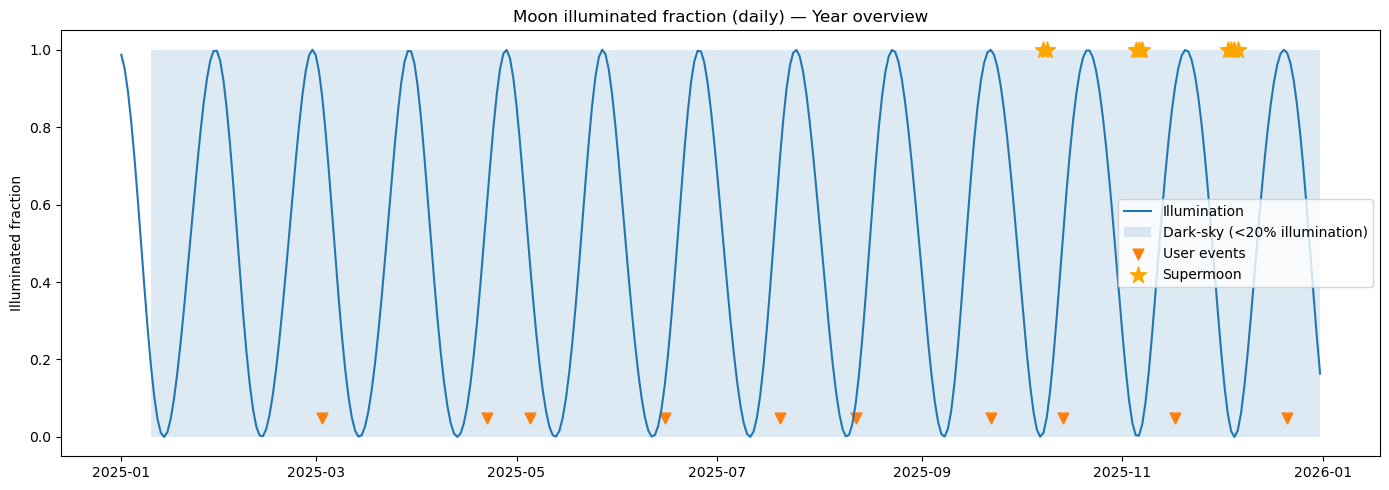

In [47]:
# Simple plot: illuminated fraction through the year, with event markers and dark-sky shading
fig, ax = plt.subplots(figsize=(14,5))
dates = pd.to_datetime(lunar_df.reset_index()['date'])
ax.plot(dates, lunar_df['illum_frac'], linewidth=1.5, label='Illumination')

# Shade dark-sky days
dark_dates = lunar_df[lunar_df['dark_sky']].reset_index()
ax.fill_between(pd.to_datetime(dark_dates['date']), 0, 1, alpha=0.15, label='Dark-sky (<20% illumination)')

# Mark user events
ev_dates = pd.to_datetime(events['date'])
ax.scatter(ev_dates, [0.05]*len(ev_dates), marker='v', s=60, label='User events')

# mark supermoons
if supermoon_dates:
    ax.scatter(pd.to_datetime(supermoon_dates), [1.0]*len(supermoon_dates), marker='*', s=150, color='orange', label='Supermoon')

ax.set_ylabel('Illuminated fraction')
ax.set_title('Moon illuminated fraction (daily) — Year overview')
ax.set_ylim(-0.05, 1.05)
ax.legend()
plt.tight_layout()
plt.show()


In [48]:
def monthly_report(df, year, month):
    """Return a small report (dict) summarizing dark-sky nights and events for a month."""
    idx = (pd.to_datetime(df.reset_index()['date']).dt.year == year) & (pd.to_datetime(df.reset_index()['date']).dt.month == month)
    month_df = df.reset_index()[idx].set_index('date')
    dark_nights = month_df[month_df['dark_sky']]
    
    # Get events for the month
    events = df.reset_index()
    if 'has_event' in events.columns:
        month_events = events[(pd.to_datetime(events['date']).dt.year==year) & (pd.to_datetime(events['date']).dt.month==month) & events['has_event']]
    else:
        # If has_event column doesn't exist, check for non-null title
        month_events = events[(pd.to_datetime(events['date']).dt.year==year) & (pd.to_datetime(events['date']).dt.month==month) & events['title'].notna()]
    
    report = {
        'year': year,
        'month': month,
        'num_days': len(month_df),
        'dark_nights': dark_nights.index.tolist(),
        'events': month_events[['title','date','category','notes']].to_dict(orient='records') if not month_events.empty else []
    }
    return report

# Example monthly report for April 2025
report_april = monthly_report(merged, 2025, 4)
report_april


{'year': 2025,
 'month': 4,
 'num_days': 30,
 'dark_nights': [datetime.date(2025, 4, 9),
  datetime.date(2025, 4, 10),
  datetime.date(2025, 4, 11),
  datetime.date(2025, 4, 12),
  datetime.date(2025, 4, 13),
  datetime.date(2025, 4, 14),
  datetime.date(2025, 4, 15),
  datetime.date(2025, 4, 16),
  datetime.date(2025, 4, 17)],
 'events': [{'title': 'Planned Observation',
   'date': datetime.date(2025, 4, 22),
   'category': 'observation',
   'notes': 'Deep-sky imaging - target: M42'}]}